In [1]:
import tensorflow as tf
from tensorflow import keras as keras
from keras import layers as layers
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf
import pandas as pd
import sys

2024-04-05 17:47:34.284848: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-05 17:47:35.347546: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import random

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[1], 'GPU')

Num GPUs Available:  2


In [4]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\wheat\data\BULK\\"
    SLASH="\\"

In [5]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TRAIN_IMAGE_COUNT = 1200
VAL_IMAGE_COUNT = 400
TEST_IMAGE_COUNT = 400
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [6]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 64

LEARNING_RATE_BASE = 0.0001

In [7]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(2).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [8]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [9]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [10]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [11]:
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [32]:
start_epoch = 101

In [33]:
model_name = "RN_"+"_IC_"+str(TRAIN_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./RNmodels/'+str(start_epoch-1)+model_name)

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

y_pred_label = np.argmax(y_pred, axis=1)

# Calculate accuracy
accuracy = accuracy_score(test_dataset_label, y_pred_label)
print("Accuracy:", accuracy)

# Calculate confusion matrix
cm = confusion_matrix(test_dataset_label, y_pred_label)
print("Confusion Matrix:")
print(cm)

# Calculate precision, recall, and F1-score for each class
print("Classification Report:")
print(classification_report(test_dataset_label, y_pred_label))

50/50 [==============================] - 1s 13ms/step
Accuracy: 0.65
Confusion Matrix:
[[385  14   0   1]
 [137 251   0  12]
 [336   3  13  48]
 [  9   0   0 391]]
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.96      0.61       400
           1       0.94      0.63      0.75       400
           2       1.00      0.03      0.06       400
           3       0.87      0.98      0.92       400

    accuracy                           0.65      1600
   macro avg       0.81      0.65      0.59      1600
weighted avg       0.81      0.65      0.59      1600



In [38]:
import seaborn as sn
import matplotlib.pyplot as plt

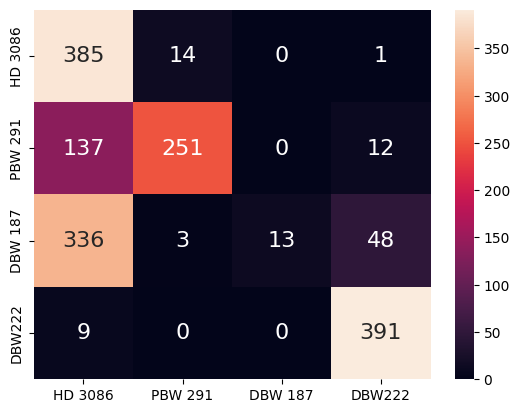

In [39]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()